# Set-up and Initializations  

In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-17-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-17-openjdk-amd64/bin"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../openjdk-17-jdk-headless_17.0.17+10-1~22.04_amd64.deb ...
Unpacking openjdk-17-jdk-headless:amd64 (17.0.17+10-1~22.04) over (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../openjdk-17-jre-headless_17.0.17+10-1~22.04_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.17+10-1~22.04) over (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Setting up openjdk-17-jre-headless:amd64 (17.0.17+10-1~22.04) ...
Installing new version of config file /etc/java-17-openjdk/security/default.policy ...
Installing new version of config file /etc/java-17-openjdk/security/java.security ...
Setting up openjdk-17-jdk-headless:amd64 (17.0.17+10-1~22.04) ...


In [ ]:
!pip install pyspark -q

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, regexp_extract, when, count, isnan, mean as _mean, stddev as _stddev,
    expr, lit
)
spark = SparkSession.builder.appName("Our Spark App").getOrCreate()


# Data Cleaning Using PySpark

In [ ]:
df = spark.read.csv("/content/car_sales_data.csv", header=True, inferSchema=True)

In [ ]:
print(df.show(5))
print("Shape of the dataset is:", (df.count(), len(df.columns)))
print(df.dtypes)
print(df.describe().show())

+------------+----------+-----------+---------+-------------------+-------+-----+
|Manufacturer|     Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|
+------------+----------+-----------+---------+-------------------+-------+-----+
|        Ford|    Fiesta|        1.0|   Petrol|               2002| 127300| 3074|
|     Porsche|718 Cayman|        4.0|   Petrol|               2016|  57850|49704|
|        Ford|    Mondeo|        1.6|   Diesel|               2014|  39190|24072|
|      Toyota|      RAV4|        1.8|   Hybrid|               1988| 210814| 1705|
|          VW|      Polo|        1.0|   Petrol|               2006| 127869| 4101|
+------------+----------+-----------+---------+-------------------+-------+-----+
only showing top 5 rows

None
Shape of the dataset is: (50000, 7)
[('Manufacturer', 'string'), ('Model', 'string'), ('Engine size', 'double'), ('Fuel type', 'string'), ('Year of manufacture', 'int'), ('Mileage', 'int'), ('Price', 'int')]
+-------+------------+--

Detect suspicious / mixed-type values

In [ ]:
numeric_pattern = "^[0-9]+(\\.[0-9]+)?$"
categorical_pattern = "^[A-Za-z0-9\\s\\-\\+\\.]+$"

suspicious_cols = {}

for c in df.columns:
    bad_rows = df.filter(
        ~(
            col(c).rlike(numeric_pattern) |
            col(c).rlike(categorical_pattern) |
            col(c).isNull()
        )
    )
    if bad_rows.count() > 0:
        suspicious_cols[c] = bad_rows.limit(10)

# print suspicious values
for colname, rows in suspicious_cols.items():
    print(f"\nSuspicious values in column: {colname}")
    rows.show(truncate=False)

Remove duplicates

In [ ]:
df = df.dropDuplicates()

Unique counts

In [ ]:
df.selectExpr("count(distinct Manufacturer)").show()
df.selectExpr("count(distinct Model)").show()
df.select("Fuel type").distinct().show()

+----------------------------+
|count(DISTINCT Manufacturer)|
+----------------------------+
|                           5|
+----------------------------+

+---------------------+
|count(DISTINCT Model)|
+---------------------+
|                   15|
+---------------------+

+---------+
|Fuel type|
+---------+
|   Diesel|
|   Hybrid|
|   Petrol|
+---------+



Missing-value check

In [ ]:
missing = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing.show()

+------------+-----+-----------+---------+-------------------+-------+-----+
|Manufacturer|Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|
+------------+-----+-----------+---------+-------------------+-------+-----+
|           0|    0|          0|        0|                  0|      0|    0|
+------------+-----+-----------+---------+-------------------+-------+-----+



Identify numeric & categorical columns

In [ ]:
numeric_cols = [f"{c}" for c, t in df.dtypes if t in ("int", "double", "float", "bigint")]
categorical_cols = [f"{c}" for c, t in df.dtypes if t == "string"]
print(numeric_cols)
print(categorical_cols)

['Engine size', 'Year of manufacture', 'Mileage', 'Price']
['Manufacturer', 'Model', 'Fuel type']


IQR Outlier detection

In [ ]:
bounds = {}

for c in numeric_cols:
    c_safe = f"`{c}`"
    stats = df.selectExpr(
        f"percentile_approx({c_safe}, 0.25) as Q1",
        f"percentile_approx({c_safe}, 0.75) as Q3"
    ).first()

    Q1, Q3 = stats.Q1, stats.Q3
    IQR = Q3 - Q1

    bounds[c] = {
        "lower": Q1 - 1.5 * IQR,
        "upper": Q3 + 1.5 * IQR
    }

Standardize numeric columns (z-score)

In [ ]:
for c in numeric_cols:
    stats = df.select(_mean(col(c)).alias("mean"), _stddev(col(c)).alias("std")).first()
    mean_val, std_val = stats["mean"], stats["std"]

    if std_val and std_val != 0:
        df = df.withColumn(c, (col(c) - lit(mean_val)) / lit(std_val))

Saving cleaned dataset

In [ ]:
df.write.mode("overwrite").csv("car_sales_data_cleaned_spark", header=True)

# EDA Using PySpark

Update the paths below with your paths

In [ ]:
df = spark.read.csv("/content/car_sales_data_cleaned_spark/part-00000-141efa20-2181-428b-ba03-57ee9fc1669a-c000.csv", header=True, inferSchema=True)
df_copy = spark.read.csv("/content/car_sales_data_cleaned_spark/part-00000-141efa20-2181-428b-ba03-57ee9fc1669a-c000.csv", header=True, inferSchema=True)

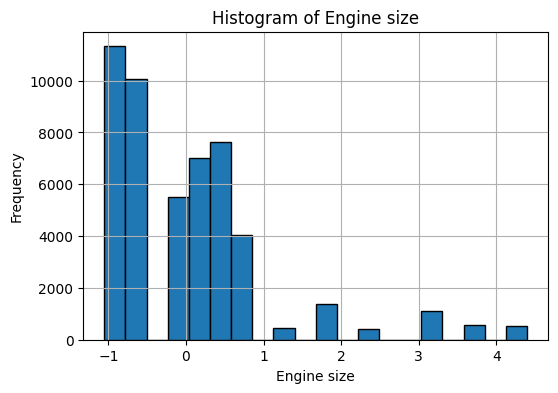

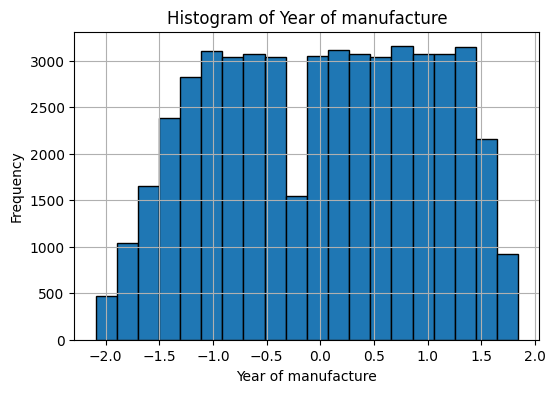

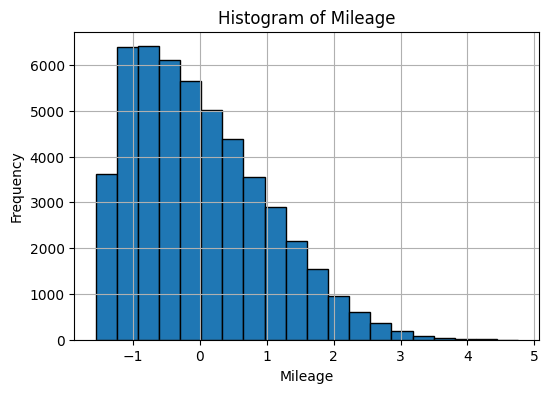

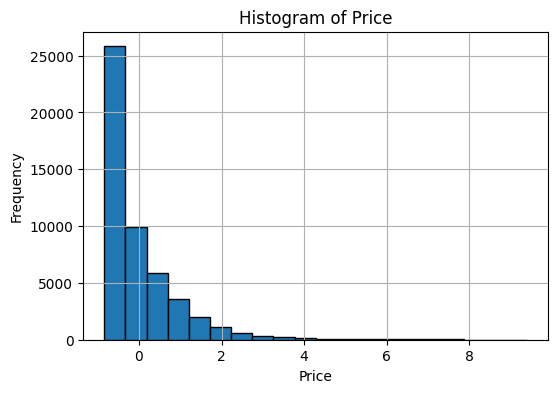

In [ ]:
import matplotlib.pyplot as plt

numeric_cols = [c for c, t in df.dtypes if t in ("int", "double", "float", "bigint")]

for c in numeric_cols:
    # Compute histogram in Spark
    hist = df.select(c).rdd.flatMap(lambda x: x).histogram(20)

    bins = hist[0]
    counts = hist[1]

    plt.figure(figsize=(6,4))
    plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge', edgecolor='black')
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


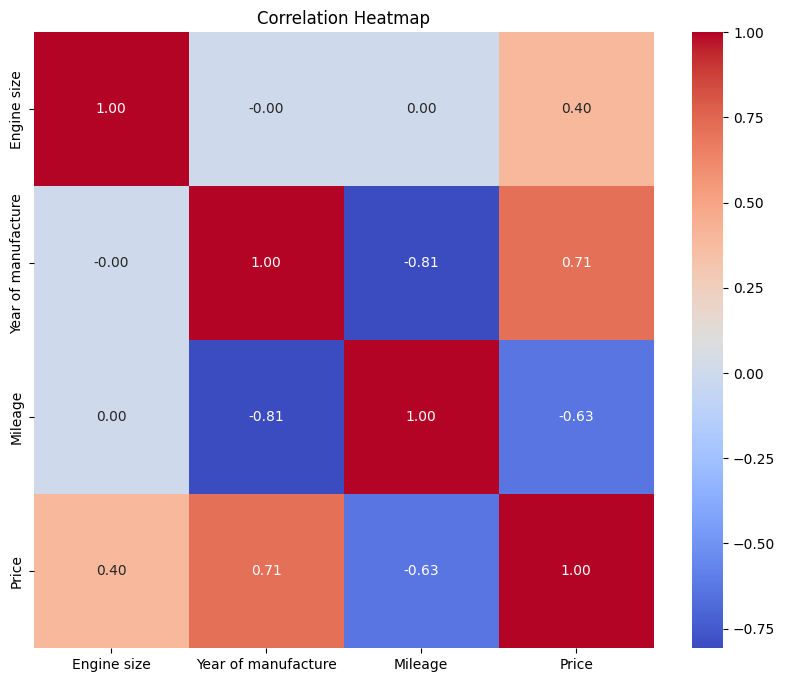

In [ ]:
import pandas as pd
import seaborn as sns

#Compute correlation matrix using Spark
corr_data = []

for c1 in numeric_cols:
    row = []
    for c2 in numeric_cols:
        corr_val = df.stat.corr(c1, c2)
        row.append(corr_val)
    corr_data.append(row)

#Convert to pandas DataFrame for plotting
corr_df = pd.DataFrame(corr_data, columns=numeric_cols, index=numeric_cols)

#Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


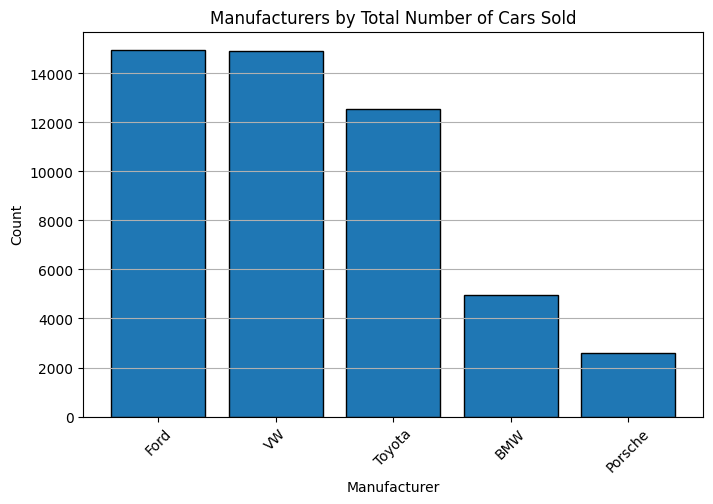

In [ ]:
# Compute counts in Spark
top_manufacturers_df = (
    df.groupBy("Manufacturer")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
)

#Convert to Pandas for plotting
pdf = top_manufacturers_df.toPandas()

#Plot
plt.figure(figsize=(8, 5))
plt.bar(pdf["Manufacturer"], pdf["count"], edgecolor="black")
plt.title("Manufacturers by Total Number of Cars Sold")
plt.xlabel("Manufacturer")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

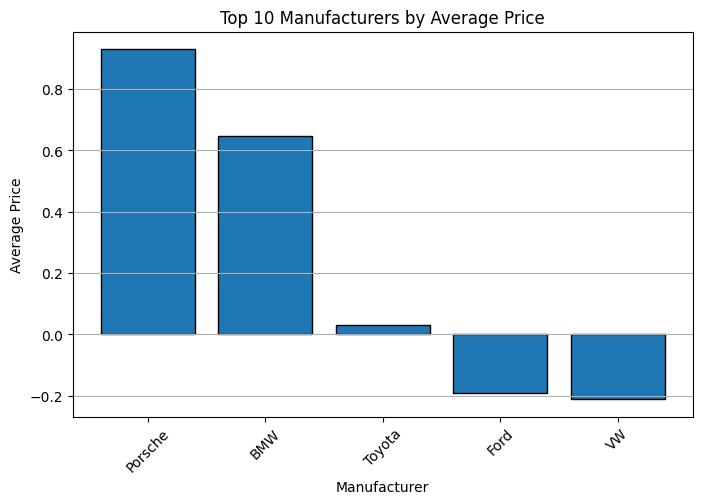

In [ ]:
from pyspark.sql.functions import avg

#Compute average price per manufacturer
avg_price_df = (
    df.groupBy("Manufacturer")
      .agg(avg("Price").alias("avg_price"))
      .orderBy("avg_price", ascending=False)
      .limit(10)
)

# 2. Convert to Pandas for plotting
pdf = avg_price_df.toPandas()

# 3. Plot
plt.figure(figsize=(8, 5))
plt.bar(pdf["Manufacturer"], pdf["avg_price"], edgecolor="black")
plt.title("Top 10 Manufacturers by Average Price")
plt.xlabel("Manufacturer")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
#Filter rows with negative prices
negative_price_df = df.filter(col("Price") < 0)

#Count how many
print("Number of negative price records:", negative_price_df.count())

#sample rows
negative_price_df.show(5)

Number of negative price records: 32818
+------------+----------+-------------------+---------+-------------------+-------------------+--------------------+
|Manufacturer|     Model|        Engine size|Fuel type|Year of manufacture|            Mileage|               Price|
+------------+----------+-------------------+---------+-------------------+-------------------+--------------------+
|     Porsche|718 Cayman|0.30901148693966757|   Petrol|-0.5400787920397662| 1.3133585229629978| -0.6265824130411829|
|        Ford|     Focus|-1.0531099921333564|   Petrol| 0.7039529563265633|-0.3794877664729337|-0.16665511538032488|
|      Toyota|     Prius|-0.5082614005041469|   Hybrid|  -1.05842535385907|  2.155795592615322|  -0.772765105980669|
|        Ford|     Focus|-1.0531099921333564|   Petrol|0.28927570687112014|-0.3934215770351409|   -0.32118240370844|
|      Toyota|      RAV4|0.30901148693966757|   Hybrid|-1.6804412280422347|  3.002127986062091| -0.8055343929812705|
+------------+----------

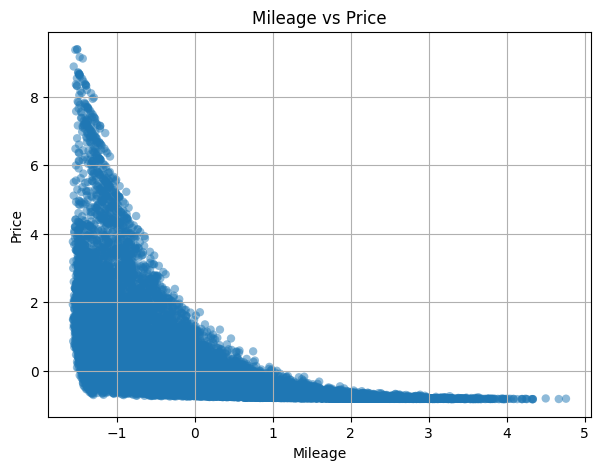

In [ ]:
scatter_df = df.select("Mileage", "Price")

#Convert to Pandas
pdf = scatter_df.toPandas()

#Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(pdf["Mileage"], pdf["Price"], alpha=0.5, edgecolors='none')
plt.title("Mileage vs Price")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.grid(True)
plt.show()

/tmp/ipython-input-3041317027.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pdf[c].dropna() for c in numeric_cols], labels=numeric_cols)


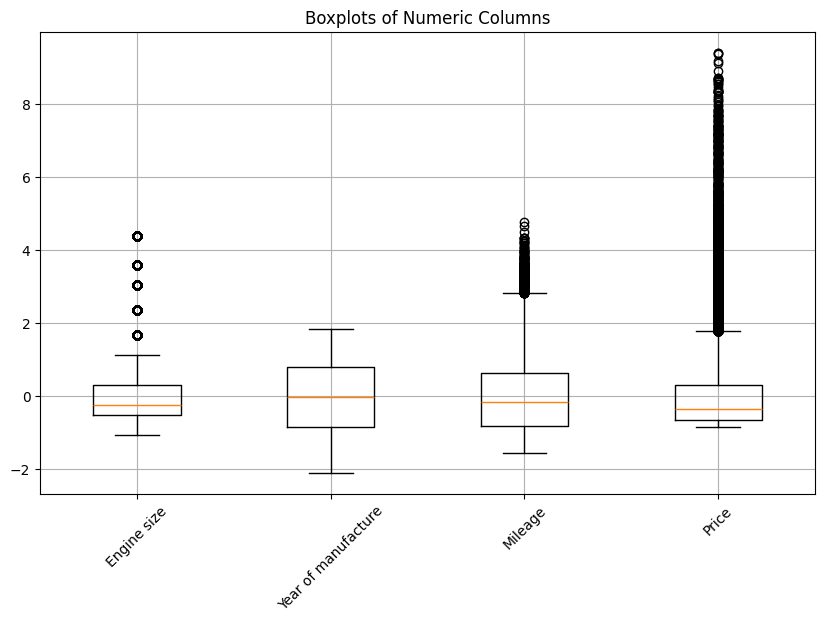

In [ ]:
pdf = df.select(numeric_cols).toPandas()

#Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([pdf[c].dropna() for c in numeric_cols], labels=numeric_cols)
plt.title("Boxplots of Numeric Columns")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

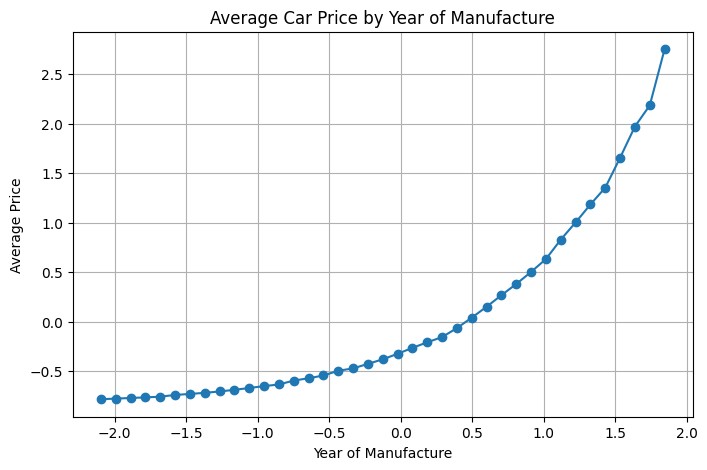

In [ ]:
#Compute average price per year in Spark
avg_price_year_df = (
    df.groupBy("Year of manufacture")
      .agg(avg("Price").alias("avg_price"))
      .orderBy("Year of manufacture")
)

# 2. Convert to Pandas for plotting
pdf = avg_price_year_df.toPandas()

# 3. Line plot
plt.figure(figsize=(8, 5))
plt.plot(pdf["Year of manufacture"], pdf["avg_price"], marker='o')
plt.title("Average Car Price by Year of Manufacture")
plt.xlabel("Year of Manufacture")
plt.ylabel("Average Price")
plt.grid(True)
plt.show()

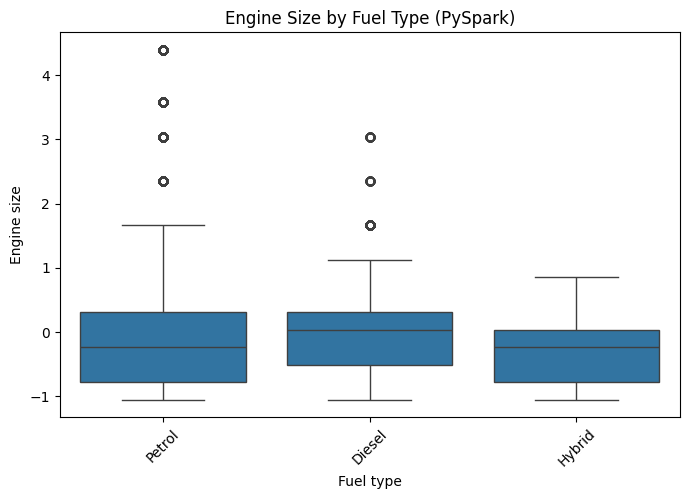

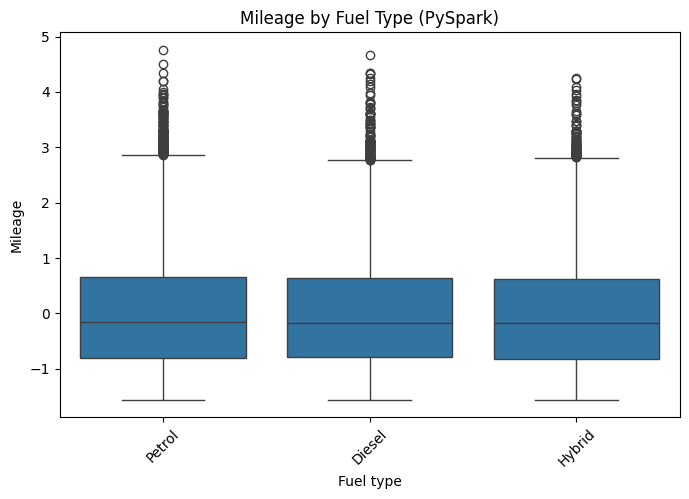

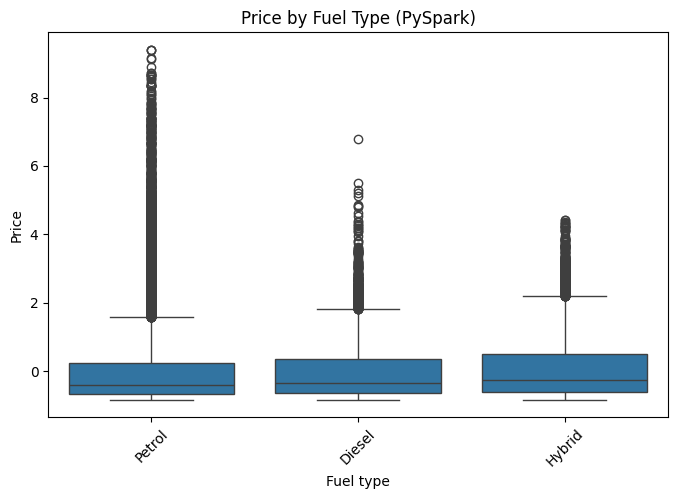

In [ ]:
# Columns needed
cols_needed = ["Fuel type", "Engine size", "Mileage", "Price"]

#Select only required columns in Spark
fuel_df = df.select(cols_needed)

#Convert to Pandas for plotting
pdf = fuel_df.toPandas()

#Boxplots

# Engine size vs Fuel type
plt.figure(figsize=(8, 5))
sns.boxplot(data=pdf, x="Fuel type", y="Engine size")
plt.title("Engine Size by Fuel Type (PySpark)")
plt.xticks(rotation=45)
plt.show()

# Mileage vs Fuel type
plt.figure(figsize=(8, 5))
sns.boxplot(data=pdf, x="Fuel type", y="Mileage")
plt.title("Mileage by Fuel Type (PySpark)")
plt.xticks(rotation=45)
plt.show()

# Price vs Fuel type
plt.figure(figsize=(8, 5))
sns.boxplot(data=pdf, x="Fuel type", y="Price")
plt.title("Price by Fuel Type (PySpark)")
plt.xticks(rotation=45)
plt.show()

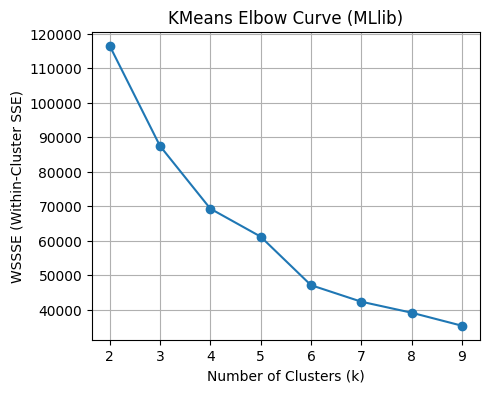

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

#Select numeric columns used in clustering
features = ["Engine size", "Mileage", "Price", "Year of manufacture"]

#Assemble into feature vector
assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
df_vec = assembler.transform(df)

#Standardize features (important!)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

#Compute WSSSE for k = 1 to 9
k_values = list(range(2, 10))
wssse_list = []

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(df_scaled)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)

#Plot elbow curve
plt.figure(figsize=(5, 4))
plt.plot(k_values, wssse_list, marker='o')
plt.title("KMeans Elbow Curve (MLlib)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE (Within-Cluster SSE)")
plt.grid(True)
plt.show()

# ML problems implementation

## Problem Statement 1

Creating price Tiers
Using quartiles to derive the tiers.

In [ ]:
from pyspark.sql.functions import col, when, lit, expr

# Compute quartiles
q1, q3 = df.approxQuantile("Price", [0.25, 0.75], 0.0)

In [ ]:
df = (
    df.withColumn(
        "Price_Tier",
        when(col("Price") <= q1, lit("Low"))
        .when(col("Price") <= q3, lit("Medium"))
        .otherwise(lit("High"))
    )
)


In [ ]:
df = df.drop("Price")

In [ ]:
df.show(5)

+------------+----------+-------------------+---------+-------------------+-------------------+----------+
|Manufacturer|     Model|        Engine size|Fuel type|Year of manufacture|            Mileage|Price_Tier|
+------------+----------+-------------------+---------+-------------------+-------------------+----------+
|        Ford|    Fiesta|-0.5082614005041469|   Petrol| 1.0149608934181455|-0.9915701863598708|    Medium|
|     Porsche|718 Cayman|0.30901148693966757|   Petrol|-0.5400787920397662| 1.3133585229629978|    Medium|
|        Ford|    Mondeo|0.03658719112506281|   Diesel|  0.807622268690424|-1.0135180322554516|      High|
|      Toyota|      RAV4|0.30901148693966757|   Hybrid| 0.6002836439627025|0.05910614635389663|    Medium|
|        Ford|     Focus|-1.0531099921333564|   Petrol| 0.7039529563265633|-0.3794877664729337|    Medium|
+------------+----------+-------------------+---------+-------------------+-------------------+----------+
only showing top 5 rows



Onehotencoding to convert categorical features to numerical

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

cat_cols = ["Manufacturer", "Model", "Fuel type"]

# Index categorical columns
indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="keep"      # handles unseen categories safely
    )
    for c in cat_cols
]
# One-hot encode
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols]
)

# Assemble all OHE vectors into a single feature vector
numeric_cols = ["Engine size", "Year of manufacture", "Mileage"]

feature_cols = [f"{c}_ohe" for c in cat_cols] + numeric_cols

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


In [ ]:
from pyspark.ml import Pipeline

#Build the encoding pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler])

# Fit & transform
model = pipeline.fit(df)
df_transformed = model.transform(df)

In [ ]:
df = df_transformed
df.show(5)

+------------+----------+-------------------+---------+-------------------+-------------------+----------+----------------+---------+-------------+----------------+---------------+-------------+--------------------+
|Manufacturer|     Model|        Engine size|Fuel type|Year of manufacture|            Mileage|Price_Tier|Manufacturer_idx|Model_idx|Fuel type_idx|Manufacturer_ohe|      Model_ohe|Fuel type_ohe|            features|
+------------+----------+-------------------+---------+-------------------+-------------------+----------+----------------+---------+-------------+----------------+---------------+-------------+--------------------+
|        Ford|    Fiesta|-0.5082614005041469|   Petrol| 1.0149608934181455|-0.9915701863598708|    Medium|             0.0|      4.0|          0.0|   (5,[0],[1.0])| (15,[4],[1.0])|(3,[0],[1.0])|(26,[0,9,20,23,24...|
|     Porsche|718 Cayman|0.30901148693966757|   Petrol|-0.5400787920397662| 1.3133585229629978|    Medium|             4.0|     14.0|   

In [ ]:
df = df.drop(*cat_cols)

In [ ]:
print(df.show(5))
print("Shape of the dataset is:", (df.count(), len(df.columns)))
print(df.dtypes)
print(df.describe().show())

+-------------------+-------------------+-------------------+----------+----------------+---------+-------------+----------------+---------------+-------------+--------------------+
|        Engine size|Year of manufacture|            Mileage|Price_Tier|Manufacturer_idx|Model_idx|Fuel type_idx|Manufacturer_ohe|      Model_ohe|Fuel type_ohe|            features|
+-------------------+-------------------+-------------------+----------+----------------+---------+-------------+----------------+---------------+-------------+--------------------+
|-0.5082614005041469| 1.0149608934181455|-0.9915701863598708|    Medium|             0.0|      4.0|          0.0|   (5,[0],[1.0])| (15,[4],[1.0])|(3,[0],[1.0])|(26,[0,9,20,23,24...|
|0.30901148693966757|-0.5400787920397662| 1.3133585229629978|    Medium|             4.0|     14.0|          0.0|   (5,[4],[1.0])|(15,[14],[1.0])|(3,[0],[1.0])|(26,[4,19,20,23,2...|
|0.03658719112506281|  0.807622268690424|-1.0135180322554516|      High|             0.0| 

In [ ]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="Price_Tier",
    outputCol="label",
    handleInvalid="keep"
)


In [ ]:
train_df, test_df = df_transformed.randomSplit([0.7, 0.3], seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression

softmax_clf = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=500,
    family="multinomial"
)


In [ ]:
from pyspark.ml import Pipeline

full_pipeline = Pipeline(
    stages=[label_indexer, softmax_clf]
)


In [ ]:
model = full_pipeline.fit(train_df)

In [ ]:
predictions = model.transform(test_df)
predictions.select("Price_Tier", "label", "prediction", "probability").show(10, truncate=False)

+----------+-----+----------+---------------------------------------------------------------------------------------+
|Price_Tier|label|prediction|probability                                                                            |
+----------+-----+----------+---------------------------------------------------------------------------------------+
|Medium    |0.0  |0.0       |[0.9999999999991951,8.049836896006983E-13,1.4142983165198877E-35,1.901243018260144E-33]|
|Low       |1.0  |1.0       |[3.8435442350656944E-14,0.9999999999999616,3.38781320812189E-67,2.6471708119188035E-43]|
|Medium    |0.0  |0.0       |[1.0,1.3595177255864172E-22,3.122253658534066E-28,1.35835989647446E-34]                |
|Medium    |0.0  |0.0       |[0.9999997815532335,2.1844676639473982E-7,4.389638445598941E-39,1.796836169685603E-32] |
|Low       |1.0  |1.0       |[1.8088061836433902E-24,1.0,1.5919234556784584E-84,5.671264725353906E-52]              |
|Low       |1.0  |1.0       |[9.737446117970304E-31,1.0,

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9864141346539954


In [ ]:
confusion = (
    predictions.groupBy("label", "prediction")
               .count()
               .orderBy("label", "prediction")
)

confusion.show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 7319|
|  0.0|       1.0|   40|
|  0.0|       2.0|   58|
|  1.0|       0.0|   46|
|  1.0|       1.0| 3670|
|  2.0|       0.0|   59|
|  2.0|       2.0| 3750|
+-----+----------+-----+



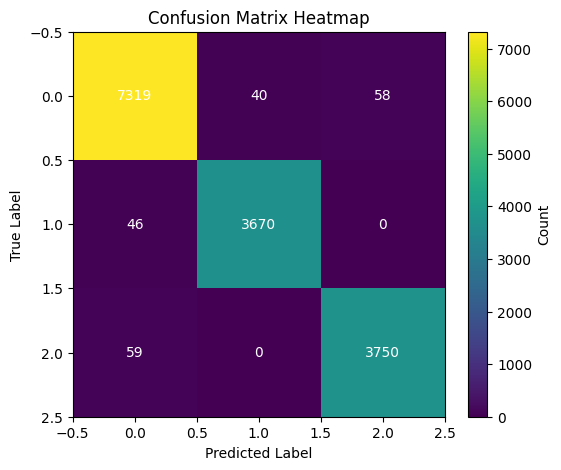

In [ ]:
conf_pd = confusion.toPandas()

# Pivot to matrix form
cm = conf_pd.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(6, 5))
plt.imshow(cm, aspect='auto')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar(label="Count")

# Annotate each cell with count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm.iloc[i, j]),
                 ha='center', va='center', color='white', fontsize=10)

plt.show()

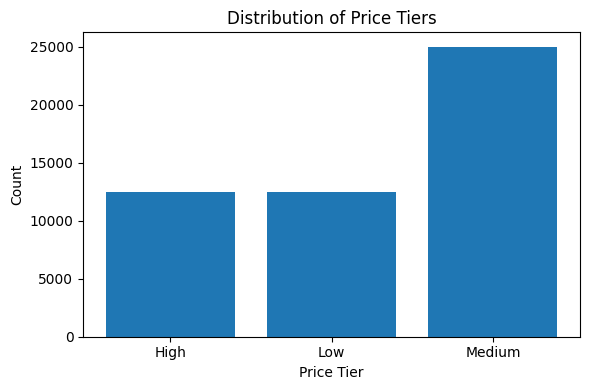

In [ ]:
tier_counts = (
    df_transformed
    .groupBy("Price_Tier")
    .count()
    .toPandas()
    .sort_values("Price_Tier")
)

plt.figure(figsize=(6,4))
plt.bar(tier_counts["Price_Tier"], tier_counts["count"])
plt.title("Distribution of Price Tiers")
plt.xlabel("Price Tier")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Problem Statement 2

In [ ]:
numeric_features = ["Engine size", "Year of manufacture", "Mileage", "Price_Tier"]
df_num = df.select(numeric_features).dropna()


In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Price_Tier", outputCol="Price_Tier_idx")
df_num = indexer.fit(df_num).transform(df_num)

numeric_features = ["Engine size", "Year of manufacture", "Mileage", "Price_Tier_idx"]

assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features_raw"
)

df_vec = assembler.transform(df_num)


In [ ]:

assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features_raw"
)

df_vec = assembler.transform(df_num)

In [ ]:

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

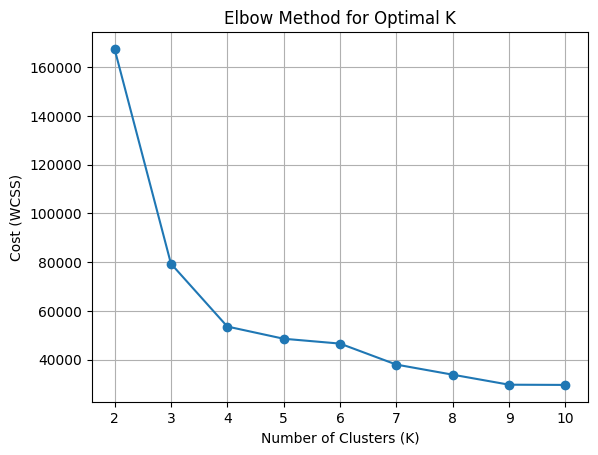

In [ ]:
cost = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(df_scaled)
    cost.append(model.summary.trainingCost)

plt.plot(K_range, cost, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [ ]:
best_k = 3
kmeans = KMeans(k=best_k, seed=42, featuresCol="features")
model = kmeans.fit(df_scaled)

df_clustered = model.transform(df_scaled)
df_clustered.show(10)

+-------------------+-------------------+-------------------+----------+--------------+--------------------+--------------------+----------+
|        Engine size|Year of manufacture|            Mileage|Price_Tier|Price_Tier_idx|        features_raw|            features|prediction|
+-------------------+-------------------+-------------------+----------+--------------+--------------------+--------------------+----------+
|-0.5082614005041469| 1.0149608934181455|-0.9915701863598708|    Medium|           0.0|[-0.5082614005041...|[-0.5082614005043...|         1|
|0.30901148693966757|-0.5400787920397662| 1.3133585229629978|    Medium|           0.0|[0.30901148693966...|[0.30901148693950...|         0|
|0.03658719112506281|  0.807622268690424|-1.0135180322554516|      High|           1.0|[0.03658719112506...|[0.03658719112489...|         1|
|0.30901148693966757| 0.6002836439627025|0.05910614635389663|    Medium|           0.0|[0.30901148693966...|[0.30901148693950...|         0|
|-1.053109992

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features_raw")
silhouette = evaluator.evaluate(df_clustered)
print("Silhouette Score:", silhouette)


Silhouette Score: 0.5508739915940056


In [ ]:
profile = (
    df_clustered.groupBy("prediction")
    .mean()
    .select(
        "prediction",
        "avg(Engine size)",
        "avg(Year of manufacture)",
        "avg(Mileage)",
        "avg(Price_Tier_idx)"
    )
    .orderBy("prediction")
)

profile.show(truncate=False)


+----------+---------------------+------------------------+--------------------+---------------------+
|prediction|avg(Engine size)     |avg(Year of manufacture)|avg(Mileage)        |avg(Price_Tier_idx)  |
+----------+---------------------+------------------------+--------------------+---------------------+
|0         |-0.031481517183454884|-0.06324808187780238    |-0.07986424625956885|0.0019835408313990293|
|1         |0.31166740661109177  |1.1723509881891807      |-1.0020951782305887 |0.9024354885474051   |
|2         |-0.28437296886743313 |-1.174289104021988      |1.257684915898989   |2.0                  |
+----------+---------------------+------------------------+--------------------+---------------------+



In [ ]:
cluster_labels = {
    0: "Economy",
    1: "Mid-Range",
    2: "Premium"
}

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

label_udf = udf(lambda x: cluster_labels[int(x)], StringType())

df_final = df_clustered.withColumn("Segment", label_udf(df_clustered["prediction"]))

df_final.show(10)

+-------------------+-------------------+-------------------+----------+--------------+--------------------+--------------------+----------+---------+
|        Engine size|Year of manufacture|            Mileage|Price_Tier|Price_Tier_idx|        features_raw|            features|prediction|  Segment|
+-------------------+-------------------+-------------------+----------+--------------+--------------------+--------------------+----------+---------+
|-0.5082614005041469| 1.0149608934181455|-0.9915701863598708|    Medium|           0.0|[-0.5082614005041...|[-0.5082614005043...|         1|Mid-Range|
|0.30901148693966757|-0.5400787920397662| 1.3133585229629978|    Medium|           0.0|[0.30901148693966...|[0.30901148693950...|         0|  Economy|
|0.03658719112506281|  0.807622268690424|-1.0135180322554516|      High|           1.0|[0.03658719112506...|[0.03658719112489...|         1|Mid-Range|
|0.30901148693966757| 0.6002836439627025|0.05910614635389663|    Medium|           0.0|[0.3090

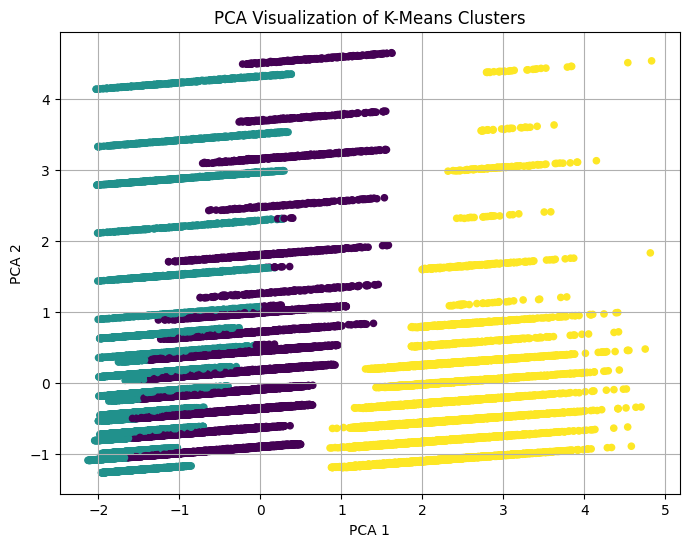

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_clustered)
df_pca = pca_model.transform(df_clustered).select("pca_features", "prediction")

pdf = df_pca.toPandas()

x = pdf["pca_features"].apply(lambda v: float(v[0]))
y = pdf["pca_features"].apply(lambda v: float(v[1]))
clusters = pdf["prediction"]

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=clusters, cmap='viridis', s=20)
plt.title("PCA Visualization of K-Means Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


## Problem Statement 3

In [ ]:
print(df_copy.show())

+------------+----------+--------------------+---------+-------------------+-------------------+--------------------+
|Manufacturer|     Model|         Engine size|Fuel type|Year of manufacture|            Mileage|               Price|
+------------+----------+--------------------+---------+-------------------+-------------------+--------------------+
|        Ford|    Fiesta| -0.5082614005041469|   Petrol| 1.0149608934181455|-0.9915701863598708| 0.05432438877986489|
|     Porsche|718 Cayman| 0.30901148693966757|   Petrol|-0.5400787920397662| 1.3133585229629978| -0.6265824130411829|
|        Ford|    Mondeo| 0.03658719112506281|   Diesel|  0.807622268690424|-1.0135180322554516|  0.5127289500559367|
|      Toyota|      RAV4| 0.30901148693966757|   Hybrid| 0.6002836439627025|0.05910614635389663| 0.19746160894977835|
|        Ford|     Focus| -1.0531099921333564|   Petrol| 0.7039529563265633|-0.3794877664729337|-0.16665511538032488|
|      Toyota|     Prius| -0.5082614005041469|   Hybrid|

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [ ]:
at_cols = ["Manufacturer", "Model", "Fuel type"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_ohe") for c in cat_cols]

numeric_cols = ["Engine size", "Year of manufacture", "Mileage"]

In [ ]:
assembler = VectorAssembler(
    inputCols=[c+"_ohe" for c in cat_cols] + numeric_cols,
    outputCol="features"
)

In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="Price", numTrees=100, maxDepth=10, seed=42)

In [ ]:
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

train_df, test_df = df_copy.randomSplit([0.7, 0.3], seed=42)

In [ ]:
model = pipeline.fit(train_df)

predictions = model.transform(test_df)
predictions.select("Price", "prediction").show(20)

+--------------------+--------------------+
|               Price|          prediction|
+--------------------+--------------------+
| -0.5185290391767462|-0.15082336481472383|
| -0.7130129302416541| -0.3829690970333038|
|-0.39841559314480174| 0.12686399820559463|
| -0.5735302773952278| -0.2791142283016878|
| -0.7566850097573256|-0.38805541718324965|
| -0.7755669409286758|-0.38805541718324965|
| -0.5038498604274061|-0.16146745599495888|
| -0.7561977341141939|-0.38805541718324965|
| -0.7744705707316297|-0.38805541718324965|
| -0.4638323482352218|-0.14758901000532954|
| -0.4762578771350781|-0.15682159900175754|
| -0.6665390157779758|-0.36884071641898236|
| -0.6832891160106253|-0.38133353461352554|
|  -0.689319152094379|-0.38133353461352554|
| -0.7079574454441635|-0.38133353461352554|
| -0.7917079466074107|-0.38667249046571084|
|-0.12280030749847906| 0.31986968119788906|
|-0.40006014844037097|-0.11083163731406306|
| -0.5383246121789682|-0.30606619542126645|
| -0.7026583228251071|-0.3813335

In [ ]:

evaluator_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")

print("RMSE:", evaluator_rmse.evaluate(predictions))
print("MAE :", evaluator_mae.evaluate(predictions))
print("R²  :", evaluator_r2.evaluate(predictions))

rf_model = model.stages[-1]
print("\nFeature Importances:", rf_model.featureImportances)

RMSE: 0.11591109285441697
MAE : 0.06192537240198734
R²  : 0.9866622858178372

Feature Importances: (26,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],[0.0008779808832928229,0.0023927260286473427,0.0019898824459659886,0.017722682934646076,0.019695853557456414,0.00049246182882755,0.0004914676748104994,0.0001247357026431742,0.004656656805419605,0.003241313028612686,0.0007122998231963411,0.013887275527845053,0.0008827784241798216,0.0008984405561775996,0.05264123352616612,0.0027541655784330725,0.0023110407505016065,0.003339031737435494,0.001726201652011814,0.016298536129504788,0.008195280390265946,0.0007747623473012303,0.00203767665514121,0.1540342897278393,0.4561384765648224,0.23168274971885613])


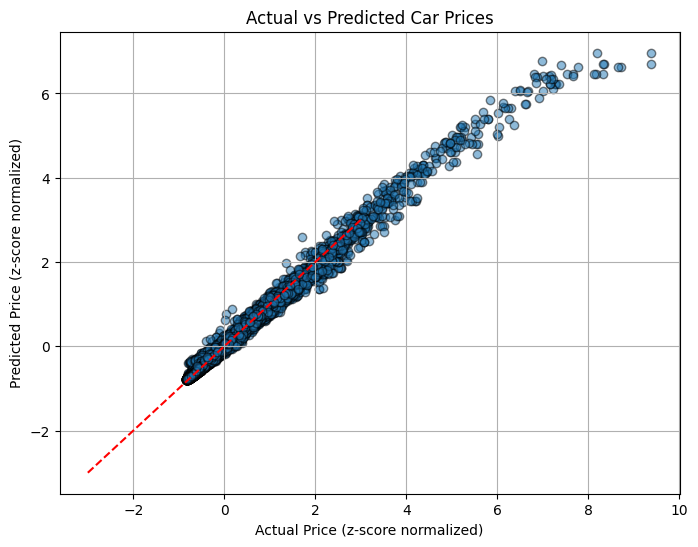

In [ ]:
pred_pdf = predictions.select("Price", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(pred_pdf["Price"], pred_pdf["prediction"], alpha=0.5, edgecolor='k')
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')  # y = x line
plt.xlabel("Actual Price (z-score normalized)")
plt.ylabel("Predicted Price (z-score normalized)")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True)
plt.show()

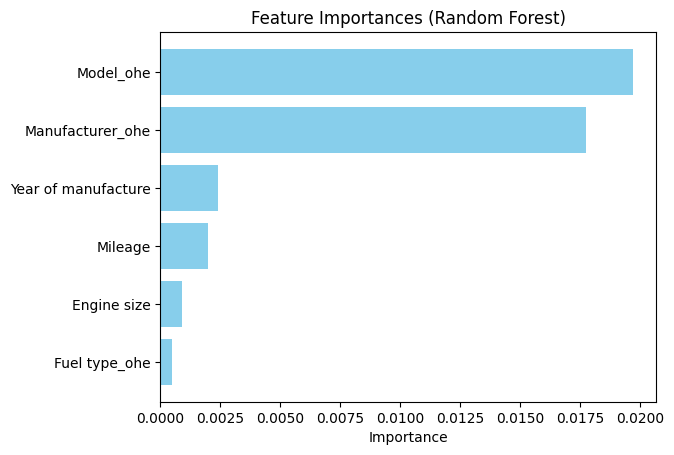

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = ["Engine size", "Year of manufacture", "Mileage",
                 "Manufacturer_ohe", "Model_ohe", "Fuel type_ohe"]

importances = rf_model.featureImportances.toArray()[:6]

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})

fi_df.sort_values("importance", inplace=True)
plt.barh(fi_df["feature"], fi_df["importance"], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances (Random Forest)")
plt.show()